In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('words')

from textblob import TextBlob

import re
import string
import contractions

from nltk.corpus import wordnet
from nltk.corpus import  stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import tqdm
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier

import keras_tuner as kt
from keras.layers import Bidirectional



[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Karthick\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karthick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("C:\\Users\\Karthick\\Downloads\\twitter_parsed_dataset.csv")

In [3]:
df = df.drop(['index','id','Annotation'], axis=1)
df.columns=('text','label')
df

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0
...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0


In [4]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [5]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))
df

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [6]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=True, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [7]:
df['correct_text'] = 'text'
df

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [8]:
count = 0
for text in tqdm.tqdm(df['cleaned_text']):
    df['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

  0%|          | 0/16851 [00:00<?, ?it/s]C:\Users\Karthick\AppData\Local\Temp\ipykernel_23940\4140034175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct_text'][count] = correct_text(text, lemma=True)
100%|██████████| 16851/16851 [01:46<00:00, 158.07it/s]


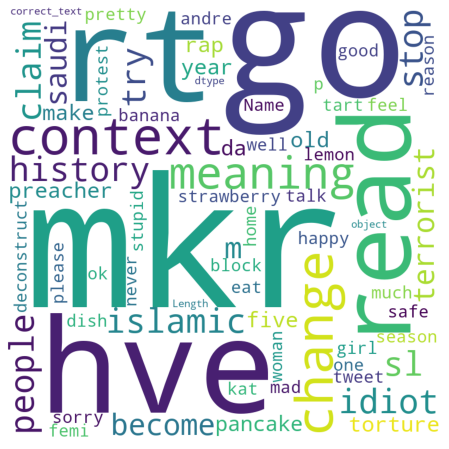

In [113]:
g = str(df[df['label']== 0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

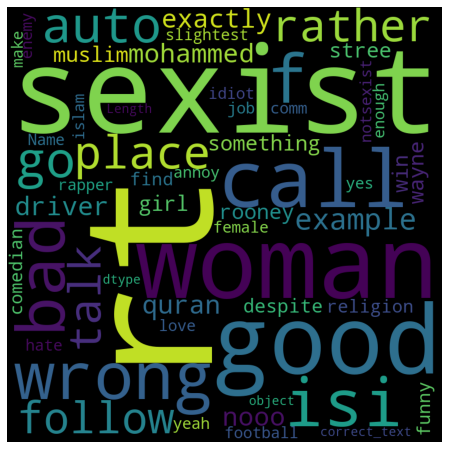

In [114]:
g = str(df[df['label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [9]:
final_data = df.drop(columns=['text', 'cleaned_text'])
final_data.to_csv("final_cleaned_data.csv", index=False)

In [10]:

X = final_data["correct_text"]
y = final_data['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [12]:
X_train.fillna(" ",axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace =True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)


In [13]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()


In [14]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [15]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded



In [16]:
vocab_set = set([x for x in vocab ])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [99]:
X.columns


AttributeError: 'Series' object has no attribute 'columns'

In [100]:
x_train = tokenizer.texts_to_sequences(df['correct_text'].values)
x_train= pad_sequences(x_train, maxlen=250)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (16851,)


In [101]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [50]:

def build_model(hp):
    model = keras.Sequential()
    model.add(Embedding(13000, 100, input_length=23))
    model.add(Bidirectional(LSTM(units=hp.Int(min_value=32,max_value=512,step=32,name=None))))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense1',min_value=32,max_value=512,step=32), activation='relu',kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
    model.add(Dense(units=hp.Int('dense2',min_value=32,max_value=512,step=32), activation='relu',kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
    model.add(Dense(units=hp.Int('dense3',min_value=32,max_value=512,step=32), activation='relu',kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
    model.add(layers.Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy'])

    return model

   

In [20]:
from keras.layers import Dropout

In [63]:
tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=10,
        directory='Project2',
        project_name='NLP1')

INFO:tensorflow:Reloading Oracle from existing project Project2\NLP1\oracle.json
INFO:tensorflow:Reloading Tuner from Project2\NLP1\tuner0.json


In [64]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

INFO:tensorflow:Oracle triggered exit


In [65]:
tuner.results_summary()

Results summary
Results in Project2\NLP1
Showing 10 best trials
Trial summary
Hyperparameters:
None: 64
dropout_1: 0.35000000000000003
dropout_2: 0.15000000000000002
dropout_3: 0.45
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.8353604078292847
Trial summary
Hyperparameters:
None: 96
dropout_1: 0.2
dropout_2: 0.5
dropout_3: 0.05
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.8332839012145996
Trial summary
Hyperparameters:
None: 64
dropout_1: 0.1
dropout_2: 0.15000000000000002
dropout_3: 0.15000000000000002
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8326905965805054
Trial summary
Hyperparameters:
None: 416
dropout_1: 0.25
dropout_2: 0.05
dropout_3: 0.2
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.8323

In [74]:
import graphviz
import pydot
import pydotplus

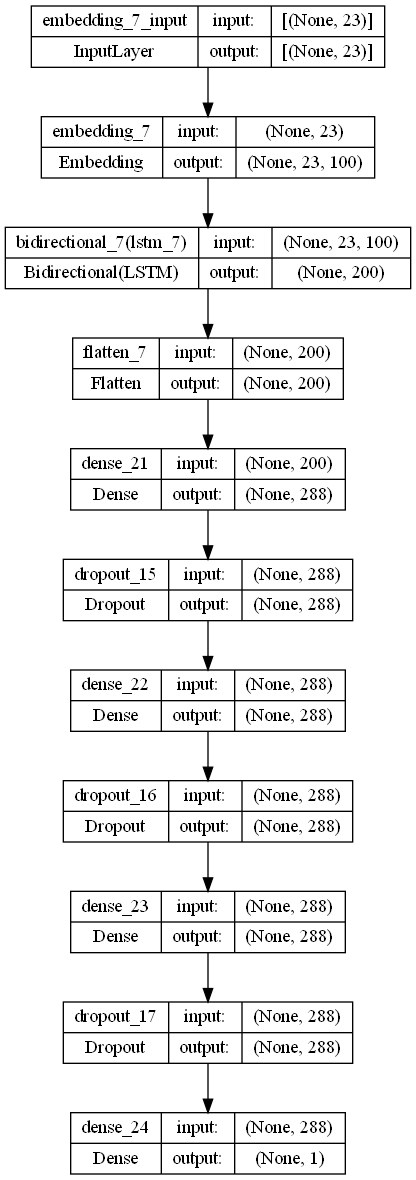

In [73]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [66]:

model = keras.Sequential()
model.add(Embedding(13000, 100, input_length=23))
model.add(Bidirectional(LSTM(100)))
model.add(Flatten())
model.add(Dense(288, activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(288,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(288, activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.45))
model.add(layers.Dense(1, activation='sigmoid'))
optimizer = Adam(0.001)
model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


   

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 23, 100)           1300000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 288)               57888     
                                                                 
 dropout_15 (Dropout)        (None, 288)               0         
                                                                 
 dense_22 (Dense)            (None, 288)               83232     
                                                      

In [90]:
history = model.fit(x_train, y_train, epochs=4, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/4
190/190 [==============================] - 16s 85ms/step - loss: 0.1554 - accuracy: 0.9547 - val_loss: 0.7482 - val_accuracy: 0.7864
Epoch 2/4
190/190 [==============================] - 15s 80ms/step - loss: 0.1336 - accuracy: 0.9631 - val_loss: 0.6883 - val_accuracy: 0.7982
Epoch 3/4
190/190 [==============================] - 15s 79ms/step - loss: 0.1246 - accuracy: 0.9648 - val_loss: 0.7205 - val_accuracy: 0.7886
Epoch 4/4
190/190 [==============================] - 14s 74ms/step - loss: 0.1057 - accuracy: 0.9706 - val_loss: 0.7036 - val_accuracy: 0.7856


In [68]:
accr = model.evaluate(x_train,y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

422/422 [==============================] - 6s 13ms/step - loss: 0.2089 - accuracy: 0.9332
Test set
  Loss: 0.209
  Accuracy: 0.933


In [79]:
acc= model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

106/106 [==============================] - 1s 13ms/step - loss: 0.5584 - accuracy: 0.8155
Test set
  Loss: 0.558
  Accuracy: 0.815


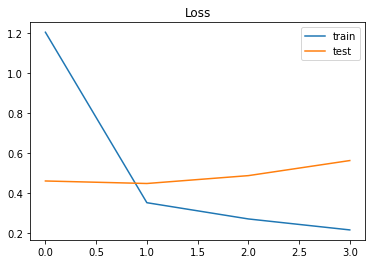

In [75]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

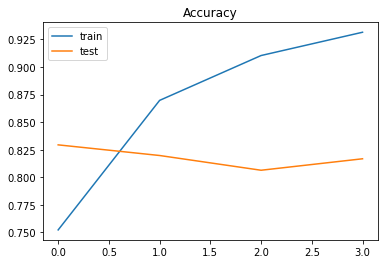

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [107]:
df

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block


In [120]:
new_tweet = ['he is cool guy']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=2)
pred = model.predict(padded)
labels = [{0:'good'},{1:'bad'}] 
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 23ms/step
[[0.09631684]] {0: 'good'}
